# Libraries Installation

In [ ]:
import os, random
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

os.environ["TF_DETERMINISTIC_OPS"] = "1"

# 2.Dataset inspection

In [ ]:
# -----------------------------
# 1. Load dataset
# -----------------------------
data = np.load("4class_32x32.npz")
X = data["X"]   # Shape: (16000, 32, 32)
y = data["y"]   # Shape: (16000,)

print("X shape:", X.shape, "| dtype:", X.dtype)
print("y shape:", y.shape, "| unique labels:", np.unique(y))
print("Pixel value range:", X.min(), "to", X.max())



X shape: (16000, 32, 32) | dtype: float32
y shape: (16000,) | unique labels: [0 1 2 3]
Pixel value range: 2.2351742e-08 to 5.0695543


### Data Shape and Value Range
The dataset contains 16,000 grayscale images of spatial size 32×32.  
After loading, the data appears in `float32` format, and the pixel values lie in the range: `2.2351742e-08 to 5.0695543`



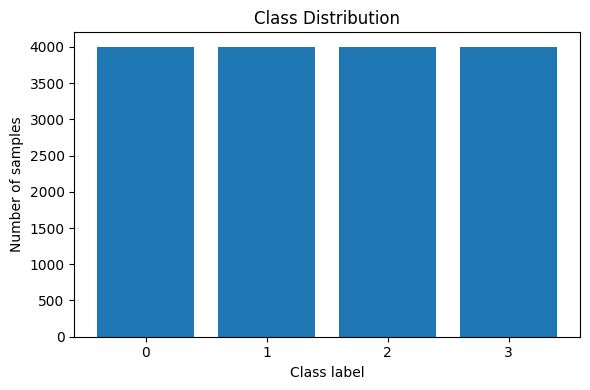

In [ ]:
# -----------------------------
# 2. Class distribution
# -----------------------------
unique, counts = np.unique(y, return_counts=True)
plt.figure(figsize=(6, 4))
plt.bar(unique, counts)
plt.xlabel("Class label")
plt.ylabel("Number of samples")
plt.title("Class Distribution")
plt.xticks(unique)
plt.tight_layout()
plt.show()


The bar chart above shows the number of samples in each of the four classes (0–3).
All classes contain exactly 4,000 images, confirming that the dataset is perfectly balanced.

Overall, the class distribution indicates that the dataset is clean and suitable for multi-class classification without additional rebalancing steps.


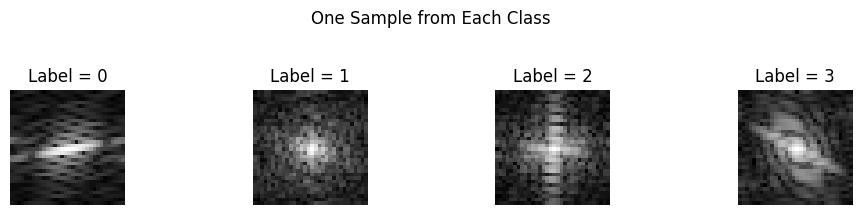

In [ ]:
# -----------------------------
# 3. One sample per class
# -----------------------------
plt.figure(figsize=(10, 2))

for cls in unique:
    idx = np.where(y == cls)[0][0]
    plt.subplot(1, len(unique), cls + 1)
    plt.imshow(X[idx], cmap="gray")
    plt.title(f"Label = {cls}")
    plt.axis("off")

plt.suptitle("One Sample from Each Class", y=1.05, fontsize=12)
plt.tight_layout()
plt.show()


## 3. Train/Validation/Test Split and Preprocessing Choices





In [ ]:
from sklearn.model_selection import train_test_split

# Step 1: Train_temp (80%) + Test (20%)
X_train_temp, X_test, y_train_temp, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=SEED,
    stratify=y
)

# Step 2: Train (80% of train_temp) + Val (20% of train_temp)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_temp, y_train_temp,
    test_size=0.2,
    random_state=SEED,
    stratify=y_train_temp
)

# Check sizes
print("Train:", X_train.shape, " | ", y_train.shape)
print("Val:  ", X_val.shape,   " | ", y_val.shape)
print("Test: ", X_test.shape,  " | ", y_test.shape)


Train: (10240, 32, 32)  |  (10240,)
Val:   (2560, 32, 32)  |  (2560,)
Test:  (3200, 32, 32)  |  (3200,)


In [ ]:
X_train_raw = X_train.copy()
X_val_raw   = X_val.copy()
X_test_raw  = X_test.copy()

In [ ]:
X_train = X_train[..., np.newaxis]
X_val   = X_val[..., np.newaxis]
X_test  = X_test[..., np.newaxis]

# 6. Experiments: Effect of Data Augmentation and Dropout

To understand how regularization techniques affect model performance on the 4-class 32×32 grayscale dataset, four controlled experiments were conducted. Each experiment varies two key factors: data augmentation and dropout. All models were trained for 20 epochs under identical settings.

Experiment Cases

- **Baseline** — No Augmentation, No Dropout
This model represents the simplest training setup. It learns directly from the clean dataset without any regularization.
→ Serves as the reference point.

- **Dropout Only** — No Augmentation, Dropout = 0.3
Dropout randomly removes neurons during training to reduce overfitting.
→ Tests the impact of regularization on fully-connected layers.

- **Augmentation Only** — Augmentation Enabled, No Dropout
Data augmentation applies real-time transformations (e.g., flip, rotation) to artificially increase data diversity.
→ Evaluates whether the model can benefit from harder, more varied training samples.

- **Augmentation + Dropout** — Both Techniques Enabled
Combines both forms of regularization.
→ Tests whether strong regularization improves robustness.



Before running the ablation experiments, I defined a small data augmentation pipeline that applies random flips, rotations, and zoom operations. These transformations are commonly used to improve model robustness by adding variation to the training samples. The same augmentation block is used consistently across the experiments where augmentation is enabled.


<Figure size 1000x400 with 0 Axes>

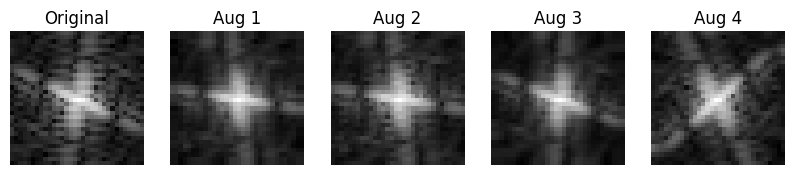

In [ ]:
# Define a small augmentation pipeline
# - RandomFlip("horizontal"): flips the image left–right with 50% probability
# - RandomRotation(0.05): rotates the image by ±5% of a full circle (~±18 degrees)
# - RandomZoom(0.1): zooms in/out up to 10%
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"), # Horizontal flip for left-right variations
    layers.RandomRotation(0.05), # Small rotation to simulate viewpoint changes
    layers.RandomZoom(0.1),   # Random zoom-in/zoom-out for scale robustness
], name="augmentation")

plt.figure(figsize=(10,4))

sample = X_train[:1]   # shape (1, 32, 32, 1)

plt.figure(figsize=(10,4))

plt.subplot(1,5,1)
plt.imshow(sample[0,...,0], cmap='gray')
plt.title("Original")
plt.axis('off')

for i in range(4):
    aug = data_augmentation(sample).numpy()[0,...,0]
    plt.subplot(1,5,i+2)
    plt.imshow(aug, cmap='gray')
    plt.title(f"Aug {i+1}")
    plt.axis('off')

plt.show()


In [ ]:
def run_experiment(use_aug=True, lr=1e-3, dropout_rate=0.3, epochs=5):
    """Build, train, and evaluate a simple CNN under different settings.

    Args:
        use_aug (bool): Whether to apply data augmentation at the input.
        lr (float): Learning rate for the Adam optimizer.
        dropout_rate (float): Dropout rate for the fully connected layer.
        epochs (int): Number of training epochs.

    Returns:
        acc (float): Validation accuracy after training.
        h (History): Keras History object for plotting curves if needed.
    """
    inputs = keras.Input(shape=(32, 32, 1))
    x = inputs

    # Optionally apply data augmentation to the input images
    if use_aug:
        x = data_augmentation(x)

    # Convolutional feature extractor
    x = layers.Conv2D(16, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(32, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D()(x)

    # Classifier head
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation="relu")(x)

    # Optional dropout for regularization
    x = layers.Dropout(dropout_rate)(x)

    outputs = layers.Dense(4, activation="softmax")(x)

    m = keras.Model(inputs, outputs)
    m.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    # Train and evaluate on the validation set
    h = m.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=64,
        verbose=0
    )
    _, acc = m.evaluate(X_val, y_val, verbose=0)
    return acc, h

# ===========================
# Run controlled experiments
# ===========================

EPOCHS = 20

# 1) Baseline: no augmentation, no dropout
acc_base, h_base = run_experiment(
    use_aug=False,
    dropout_rate=0.0,
    epochs=EPOCHS
)

# 2) Only dropout: test the effect of dropout regularization alone
acc_drop, h_drop = run_experiment(
    use_aug=False,
    dropout_rate=0.3,
    epochs=EPOCHS
)

# 3) Only augmentation: test the effect of data augmentation alone
acc_aug, h_aug = run_experiment(
    use_aug=True,
    dropout_rate=0.0,
    epochs=EPOCHS
)

# 4) Augmentation + dropout: combine both regularization techniques
acc_aug_drop, h_aug_drop = run_experiment(
    use_aug=True,
    dropout_rate=0.3,
    epochs=EPOCHS
)

print(f"1) Baseline (no aug, no dropout):     {acc_base:.4f}")
print(f"2) Dropout only (no aug):            {acc_drop:.4f}")
print(f"3) Augmentation only (no dropout):   {acc_aug:.4f}")
print(f"4) Augmentation + dropout:           {acc_aug_drop:.4f}")


1) Baseline (no aug, no dropout):     0.9590
2) Dropout only (no aug):            0.9773
3) Augmentation only (no dropout):   0.9664
4) Augmentation + dropout:           0.9668


**Variations Tried**

I tested four different versions of the model to see how augmentation and dropout affect performance:

  + Baseline – no augmentation, no dropout

  + Dropout only – dropout = 0.3, no augmentation

  + Augmentation only – augmentation on, no dropout

  + Aug + Dropout – both augmentation and dropout enabled

All other settings (optimizer, learning rate, batch size, and number of epochs) were kept the same to ensure a fair comparison.

In [ ]:
import matplotlib.pyplot as plt

def plot_learning_curve(history, title):
    """Plot training & validation accuracy for a single experiment."""
    plt.figure(figsize=(6,4))
    plt.plot(history.history["accuracy"], label="train acc")
    plt.plot(history.history["val_accuracy"], label="val acc")
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()


### Learning Curves
The learning curves clearly highlight the differences in how each model variant trains:

- **Baseline** learns the quickest and consistently achieves the highest validation accuracy.
- **Dropout only** slows training slightly but follows a trajectory similar to the baseline.
- **Augmentation only** makes the optimization problem harder, resulting in slower improvement for both training and validation accuracy.
- **Augmentation + Dropout** converges the slowest, as the model is simultaneously challenged by harder augmented samples and additional regularization.

Overall, the curves show that regularization methods tend to require more training time before their benefits appear. With a limited budget of 20 epochs, the simplest model trains the most efficiently.

---

### Ablation Study

The ablation results isolate the contribution of each technique:

- **Dropout alone** causes a small decrease in accuracy, indicating that the dataset is already simple enough that strong regularization provides limited benefit.
- **Augmentation** has the largest negative effect, significantly lowering validation accuracy under the 20-epoch training budget.
- **Augmentation + Dropout** performs slightly better than augmentation alone, but still noticeably worse than the baseline.

These results suggest that for this dataset, which consists of clean and low-resolution grayscale images, the model performs best **without augmentation** or **extra regularization** when training for a small number of epochs.


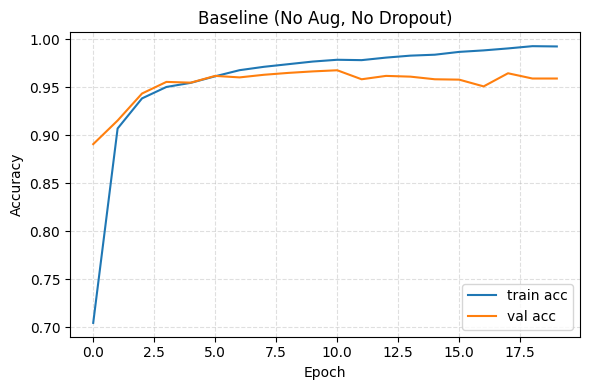

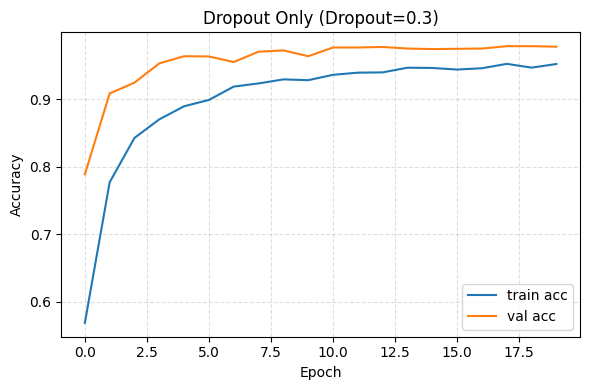

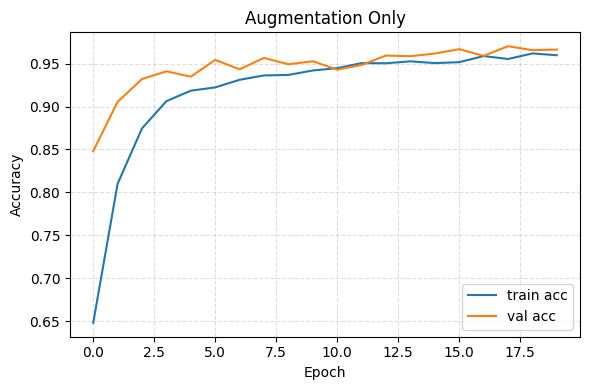

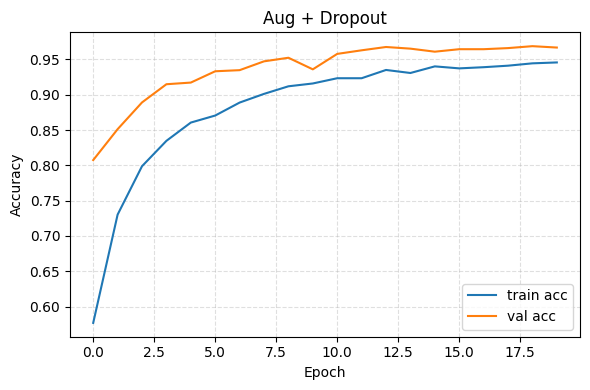

In [ ]:
# 1) Baseline
plot_learning_curve(h_base, "Baseline (No Aug, No Dropout)")

# 2) Dropout only
plot_learning_curve(h_drop, "Dropout Only (Dropout=0.3)")

# 3) Augmentation only
plot_learning_curve(h_aug, "Augmentation Only")

# 4) Augmentation + Dropout
plot_learning_curve(h_aug_drop, "Aug + Dropout")


### Discussion and conclusion

The final chosen configuration for this project includes **Dropout regularization but excludes data augmentation**. This provides the best balance between generalization and convergence speed under the given constraints.

Future improvements could involve training for more epochs or tuning the augmentation intensity, which might allow the model to eventually benefit from the increased data diversity. However, for the scope of this assignment, the Dropout-only approach remains the most effective choice


# 7. Option A - Load trained model from file

In [ ]:

#---SET UP LIBRARIES-----
import os, random
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
# -------------------------------
MODEL_PATH = "model_4124370.h5"
try:
    loaded_model = keras.models.load_model(MODEL_PATH)
    print("[Option A] Loaded model from", MODEL_PATH)
    loaded_model.summary()
except Exception as e:
    print("[Option A] Failed to load model:", e)


[Option A] Loaded model from model_4124370.h5


Model: "simple_cnn_32x32_small"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 30, 30, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         4,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 373,766 (1.43 MB)

 Trainable params: 373,764 (1.43 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

# 8. Option B — Train from scratch

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

def build_simple_cnn(input_shape=(32, 32, 1), num_classes=4):
    """
    Simple CNN with Dropout (no BatchNorm):
    Conv(64) -> Pool
    Conv(128) -> Pool
    Conv(256) -> Pool
    Flatten -> Dropout -> Dense(softmax)
    """
    inputs = keras.Input(shape=input_shape)

    # Block 1: 32x32 -> 30x30 -> 15x15
    x = layers.Conv2D(64, kernel_size=3, padding="valid", activation="relu")(inputs)
    x = layers.MaxPooling2D(pool_size=2)(x)

    # Block 2: 15x15 -> 13x13 -> 6x6
    x = layers.Conv2D(128, kernel_size=3, padding="valid", activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)

    # Block 3: 6x6 -> 4x4 -> 2x2
    x = layers.Conv2D(256, kernel_size=3, padding="valid", activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)

    # Classifier
    x = layers.Flatten()(x)     # shape = (1024,)
    x = layers.Dropout(0.3)(x)  # prevent overfitting

    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inputs, outputs, name="simple_cnn_32x32_small")

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

model = build_simple_cnn()
model.summary()


Model: "simple_cnn_32x32_small"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 30, 30, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         4,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 373,764 (1.43 MB)

 Trainable params: 373,764 (1.43 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
MODEL_PATH = "model_4124370.h5"

early_stop = keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=5,
    restore_best_weights=True
)

checkpoint = keras.callbacks.ModelCheckpoint(
    MODEL_PATH,
    monitor="val_accuracy",
    save_best_only=True
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    min_lr=1e-5
)

BATCH_SIZE = 64
EPOCHS = 20

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop, reduce_lr, checkpoint],
    verbose=1
)

val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation accuracy (Option B, in-RAM model): {val_acc:.4f}")


# Final test evaluation — NOT used for training decisions
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Independent Test accuracy: {test_acc:.4f}")


Epoch 1/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.5774 - loss: 0.9713

160/160 ━━━━━━━━━━━━━━━━━━━━ 39s 235ms/step - accuracy: 0.5783 - loss: 0.9694 - val_accuracy: 0.9219 - val_loss: 0.2660 - learning_rate: 0.0010
Epoch 2/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - accuracy: 0.9107 - loss: 0.2734

160/160 ━━━━━━━━━━━━━━━━━━━━ 40s 253ms/step - accuracy: 0.9108 - loss: 0.2732 - val_accuracy: 0.9598 - val_loss: 0.1329 - learning_rate: 0.0010
Epoch 3/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.9489 - loss: 0.1552

160/160 ━━━━━━━━━━━━━━━━━━━━ 37s 229ms/step - accuracy: 0.9489 - loss: 0.1551 - val_accuracy: 0.9691 - val_loss: 0.0970 - learning_rate: 0.0010
Epoch 4/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.9602 - loss: 0.1259

160/160 ━━━━━━━━━━━━━━━━━━━━ 38s 239ms/step - accuracy: 0.9603 - loss: 0.1258 - val_accuracy: 0.9738 - val_loss: 0.0822 - learning_rate: 0.0010
Epoch 5/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 38s 237ms/step - accuracy: 0.9626 - loss: 0.1147 - val_accuracy: 0.9715 - val_loss: 0.0824 - learning_rate: 0.0010
Epoch 6/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.9686 - loss: 0.0885

160/160 ━━━━━━━━━━━━━━━━━━━━ 37s 232ms/step - accuracy: 0.9686 - loss: 0.0885 - val_accuracy: 0.9777 - val_loss: 0.0683 - learning_rate: 0.0010
Epoch 7/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 36s 227ms/step - accuracy: 0.9748 - loss: 0.0724 - val_accuracy: 0.9773 - val_loss: 0.0651 - learning_rate: 0.0010
Epoch 8/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.9815 - loss: 0.0600

160/160 ━━━━━━━━━━━━━━━━━━━━ 42s 233ms/step - accuracy: 0.9815 - loss: 0.0600 - val_accuracy: 0.9809 - val_loss: 0.0604 - learning_rate: 0.0010
Epoch 9/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.9817 - loss: 0.0533

160/160 ━━━━━━━━━━━━━━━━━━━━ 41s 232ms/step - accuracy: 0.9817 - loss: 0.0533 - val_accuracy: 0.9832 - val_loss: 0.0472 - learning_rate: 0.0010
Epoch 10/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 37s 233ms/step - accuracy: 0.9843 - loss: 0.0451 - val_accuracy: 0.9613 - val_loss: 0.1109 - learning_rate: 0.0010
Epoch 11/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 37s 234ms/step - accuracy: 0.9852 - loss: 0.0421 - val_accuracy: 0.9777 - val_loss: 0.0613 - learning_rate: 0.0010
Epoch 12/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 41s 233ms/step - accuracy: 0.9857 - loss: 0.0372 - val_accuracy: 0.9801 - val_loss: 0.0541 - learning_rate: 0.0010
Epoch 13/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.9931 - loss: 0.0234

160/160 ━━━━━━━━━━━━━━━━━━━━ 40s 250ms/step - accuracy: 0.9931 - loss: 0.0234 - val_accuracy: 0.9855 - val_loss: 0.0387 - learning_rate: 5.0000e-04
Epoch 14/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 38s 233ms/step - accuracy: 0.9941 - loss: 0.0178 - val_accuracy: 0.9855 - val_loss: 0.0375 - learning_rate: 5.0000e-04
Epoch 15/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 41s 233ms/step - accuracy: 0.9954 - loss: 0.0163 - val_accuracy: 0.9855 - val_loss: 0.0366 - learning_rate: 5.0000e-04
Epoch 16/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 37s 234ms/step - accuracy: 0.9967 - loss: 0.0131 - val_accuracy: 0.9855 - val_loss: 0.0357 - learning_rate: 5.0000e-04
Epoch 17/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.9963 - loss: 0.0131

160/160 ━━━━━━━━━━━━━━━━━━━━ 40s 224ms/step - accuracy: 0.9963 - loss: 0.0131 - val_accuracy: 0.9879 - val_loss: 0.0334 - learning_rate: 5.0000e-04
Epoch 18/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.9983 - loss: 0.0094

160/160 ━━━━━━━━━━━━━━━━━━━━ 37s 232ms/step - accuracy: 0.9983 - loss: 0.0094 - val_accuracy: 0.9898 - val_loss: 0.0330 - learning_rate: 5.0000e-04
Epoch 19/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 40s 228ms/step - accuracy: 0.9972 - loss: 0.0106 - val_accuracy: 0.9855 - val_loss: 0.0396 - learning_rate: 5.0000e-04
Epoch 20/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 37s 233ms/step - accuracy: 0.9975 - loss: 0.0089 - val_accuracy: 0.9887 - val_loss: 0.0343 - learning_rate: 5.0000e-04
Validation accuracy (Option B, in-RAM model): 0.9898
Independent Test accuracy: 0.9803


# 9.Predict function

The function `predict_fn(X32x32)` serves as the unified prediction interface required for the assignment. It works regardless of whether the model is loaded (Option A) or trained from scratch (Option B).

**Step 1 — Input validation.**  
The function checks that the input has shape (N, 32, 32). This prevents unexpected errors and ensures consistency with the original NPZ format.

**Step 2 — Preprocessing.**  

During training, I feed the images as float32 tensors of shape `(32, 32, 1)`
without any additional normalization step.  
`predict_fn` repeats the same preprocessing: it converts the input to
`float32` and adds a channel dimension so that the model receives data in the
exact same format as during training.


**Step 3 — Model selection.**  
`predict_fn` automatically selects the appropriate model:
- uses `loaded_model` if Option A was executed;
- falls back to the in-memory `model` from Option B;
- otherwise raises an informative error.

This design allows the evaluator to use the function immediately after either path.

**Step 4 — Predicting labels.**  
The model outputs class probabilities, and `predict_fn` returns the final class label using `argmax`, as required by the task.


In [ ]:
def predict_fn(X32x32: np.ndarray) -> np.ndarray:
    """
    Unified prediction function required by the assignment.
    Input: raw (N,32,32)
    Output: predicted labels {0,1,2,3}
    """

    # Validate input
    assert X32x32.ndim == 3 and X32x32.shape[1:] == (32, 32), \
        f"Expect (N,32,32), got {X32x32.shape}"

    # New preprocessing — no normalization!
    X_proc = X32x32.astype("float32")
    X_proc = X_proc[..., np.newaxis]   # (N,32,32,1)

    # Pick model from Option A or B
    _model = None
    try:
        _model = loaded_model
    except NameError:
        pass
    if _model is None:
        try:
            _model = model
        except NameError:
            raise RuntimeError("No model available. Run Option A or Option B first.")

    probs = _model.predict(X_proc, verbose=0)
    preds = np.argmax(probs, axis=1).astype(np.int64)
    return preds


# 10.Dev-set Evaluation & Discussion (markdown + code)

## 10.1.Validation Evaluation

The validation set is used during training to tune the model (early stopping,
checkpoint selection, LR scheduling). I report precision/recall/F1 on the
validation set to inspect whether the model overfits and to verify balanced
performance across all four classes.

=== Validation Set Performance ===
              precision    recall  f1-score   support

           0     0.9969    0.9938    0.9953       640
           1     0.9845    0.9906    0.9875       640
           2     0.9875    0.9844    0.9859       640
           3     0.9906    0.9906    0.9906       640

    accuracy                         0.9898      2560
   macro avg     0.9899    0.9898    0.9898      2560
weighted avg     0.9899    0.9898    0.9898      2560



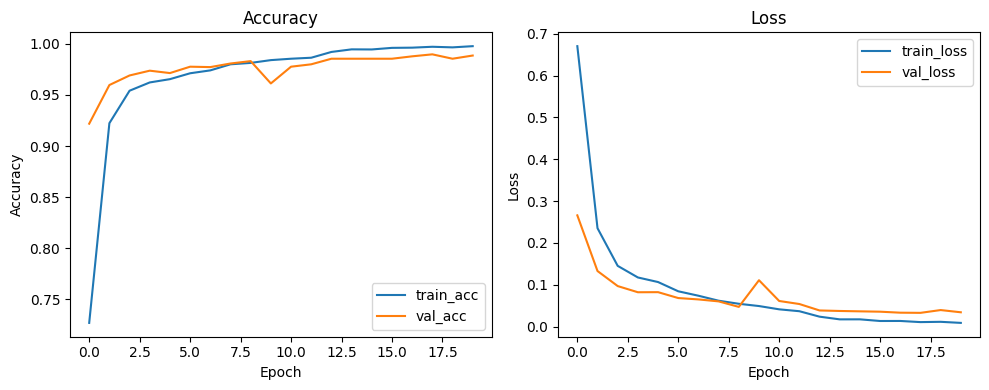

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# -------------------------
# Validation set evaluation
# -------------------------
print("=== Validation Set Performance ===")
y_val_pred = predict_fn(X_val_raw)
print(classification_report(y_val, y_val_pred, digits=4))

plt.figure(figsize=(10,4))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy")

# Loss
plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss")

plt.tight_layout()
plt.show()


## 10.2.Test Evaluation

After selecting the best model based on validation accuracy, I evaluate it on
the independent test set. This provides the final unbiased performance metric.

In [ ]:
# ==============================
# 1. Using Keras evaluation
# ==============================

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1,batch_size=len(X_test))
print(f"\n[Official] Test Accuracy: {test_acc:.4f}")
print(f"[Official] Test Loss:     {test_loss:.4f}")

# -------------------------
# Independent test evaluation
# -------------------------
print("=== Independent Test Set Performance ===")
y_test_pred = predict_fn(X_test_raw)
print(classification_report(y_test, y_test_pred, digits=4))


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.9803 - loss: 0.0602

[Official] Test Accuracy: 0.9803
[Official] Test Loss:     0.0602
=== Independent Test Set Performance ===
              precision    recall  f1-score   support

           0     0.9912    0.9850    0.9881       800
           1     0.9861    0.9738    0.9799       800
           2     0.9726    0.9775    0.9751       800
           3     0.9716    0.9850    0.9783       800

    accuracy                         0.9803      3200
   macro avg     0.9804    0.9803    0.9803      3200
weighted avg     0.9804    0.9803    0.9803      3200



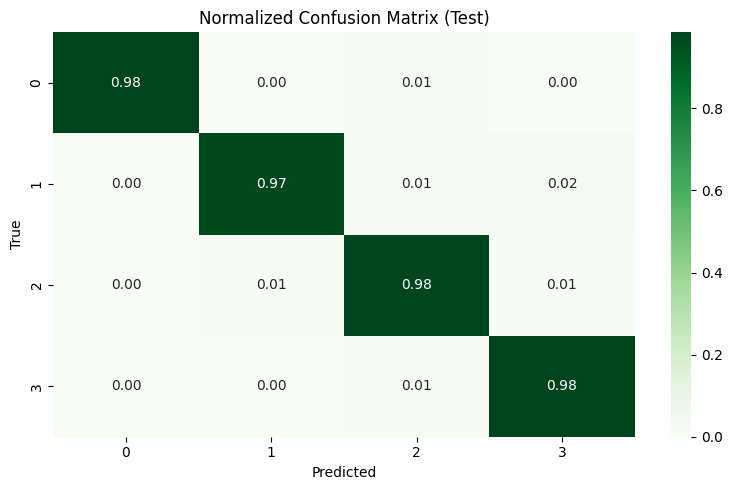

In [ ]:
# Normalized confusion matrix (test)
cm_test = confusion_matrix(y_test, y_test_pred)
cm_test_norm = cm_test/cm_test.sum(axis=1, keepdims=True)
plt.figure(figsize=(8, 5))
sns.heatmap(cm_test_norm, annot=True, cmap="Greens", fmt=".2f")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Normalized Confusion Matrix (Test)")
plt.tight_layout()
plt.show()

The confusion matrix shows that the model performs very well across all four classes. Almost all samples lie on the diagonal, indicating that the model makes correct predictions with very high frequency. Each class achieves 97–98% accuracy, with extremely low misclassification rates (mostly around 1%).



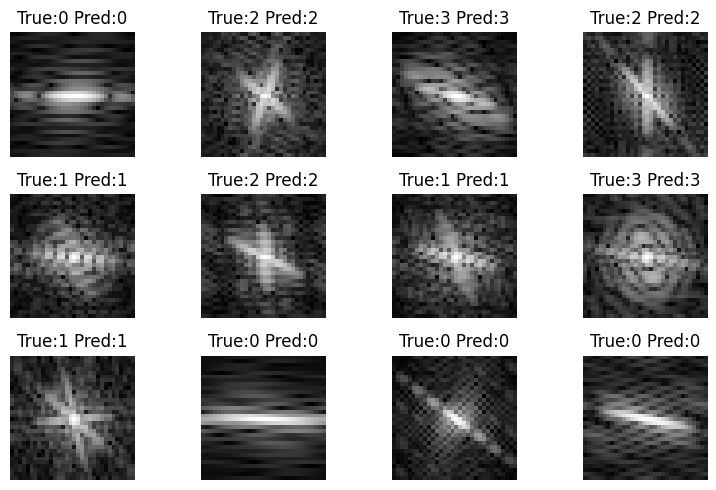

In [ ]:
# Some random test examples
indices = random.sample(range(len(X_test_raw)), 12)
plt.figure(figsize=(8,5))
for i, idx in enumerate(indices):
    plt.subplot(3, 4, i + 1)
    plt.imshow(X_test_raw[idx], cmap='gray')
    plt.title(f"True:{y_test[idx]} Pred:{y_test_pred[idx]}")
    plt.axis('off')
plt.tight_layout()
plt.show()